In [1]:
import sys
import os
import glob
import cv2
import caffe
import pandas as pd
import numpy as np
from caffe.proto import caffe_pb2
import matplotlib.pyplot as plt
%matplotlib inline

AVA_ROOT = 'AVA/'
IMAGE_MEAN= AVA_ROOT + 'mean_AADB_regression_warp256.binaryproto'
DEPLOY = AVA_ROOT + 'initModel.prototxt'
MODEL_FILE = AVA_ROOT + 'initModel.caffemodel'
IMAGE_FILE = "../images/*jpg"
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227
input_layer = 'imgLow'

# Image processing helper function
def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):
    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
    return img

In [2]:
caffe.set_mode_gpu()
# caffe.set_mode_cpu()

# Reading mean image, caffe model and its weights
mean_blob = caffe_pb2.BlobProto()
with open(IMAGE_MEAN) as f:
    mean_blob.ParseFromString(f.read())

mean_array = np.asarray(mean_blob.data, dtype=np.float32).reshape((
                 mean_blob.channels, 
                 mean_blob.height, 
                 mean_blob.width
                )
               )

net = caffe.Net(DEPLOY, MODEL_FILE, caffe.TEST)

786446

In [3]:
# Define image transformers
print "Shape mean_array : ", mean_array.shape
print "Shape net : ", net.blobs[input_layer].data.shape
net.blobs[input_layer].reshape(1,       # batch size
                               3,       # channel
                               IMAGE_WIDTH, IMAGE_HEIGHT)  # image size
transformer = caffe.io.Transformer({input_layer: net.blobs[input_layer].data.shape})
transformer.set_mean(input_layer, mean_array)
transformer.set_transpose(input_layer, (2,0,1))

Shape mean_array :  (3, 256, 256)
Shape net :  (1, 3, 227, 227)
(1, 3, 227, 227)


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
test_img_paths = [img_path for img_path in glob.glob(IMAGE_FILE)]
test_img_paths.sort()

mage_name = os.path.basename(test_img_paths[0])    
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)

net.blobs[input_layer].data[...] = transformer.preprocess(input_layer, img)
out = net.forward()

Output structure
```json
  {
        'fc9_ColorHarmony': array([[ 0.22087261]], dtype=float32), 
        'fc9_MotionBlur': array([[-0.08059776]], dtype=float32), 
        'fc9_Light': array([[ 0.14933866]], dtype=float32), 
        'fc9_Content': array([[ 0.01467544]], dtype=float32), 
        'fc9_Repetition': array([[ 0.18157494]], dtype=float32), 
        'fc11_score': array([[ 0.55613178]], dtype=float32), 
        'fc9_DoF': array([[-0.05279735]], dtype=float32), 
        'fc9_VividColor': array([[ 0.13607402]], dtype=float32), 
        'fc9_Symmetry': array([[ 0.06802807]], dtype=float32), 
        'fc9_Object': array([[ 0.00289625]], dtype=float32), 
        'fc9_BalancingElement': array([[-0.04946293]], dtype=float32), 
        'fc9_RuleOfThirds': array([[-0.0477073]], dtype=float32)
    }
```

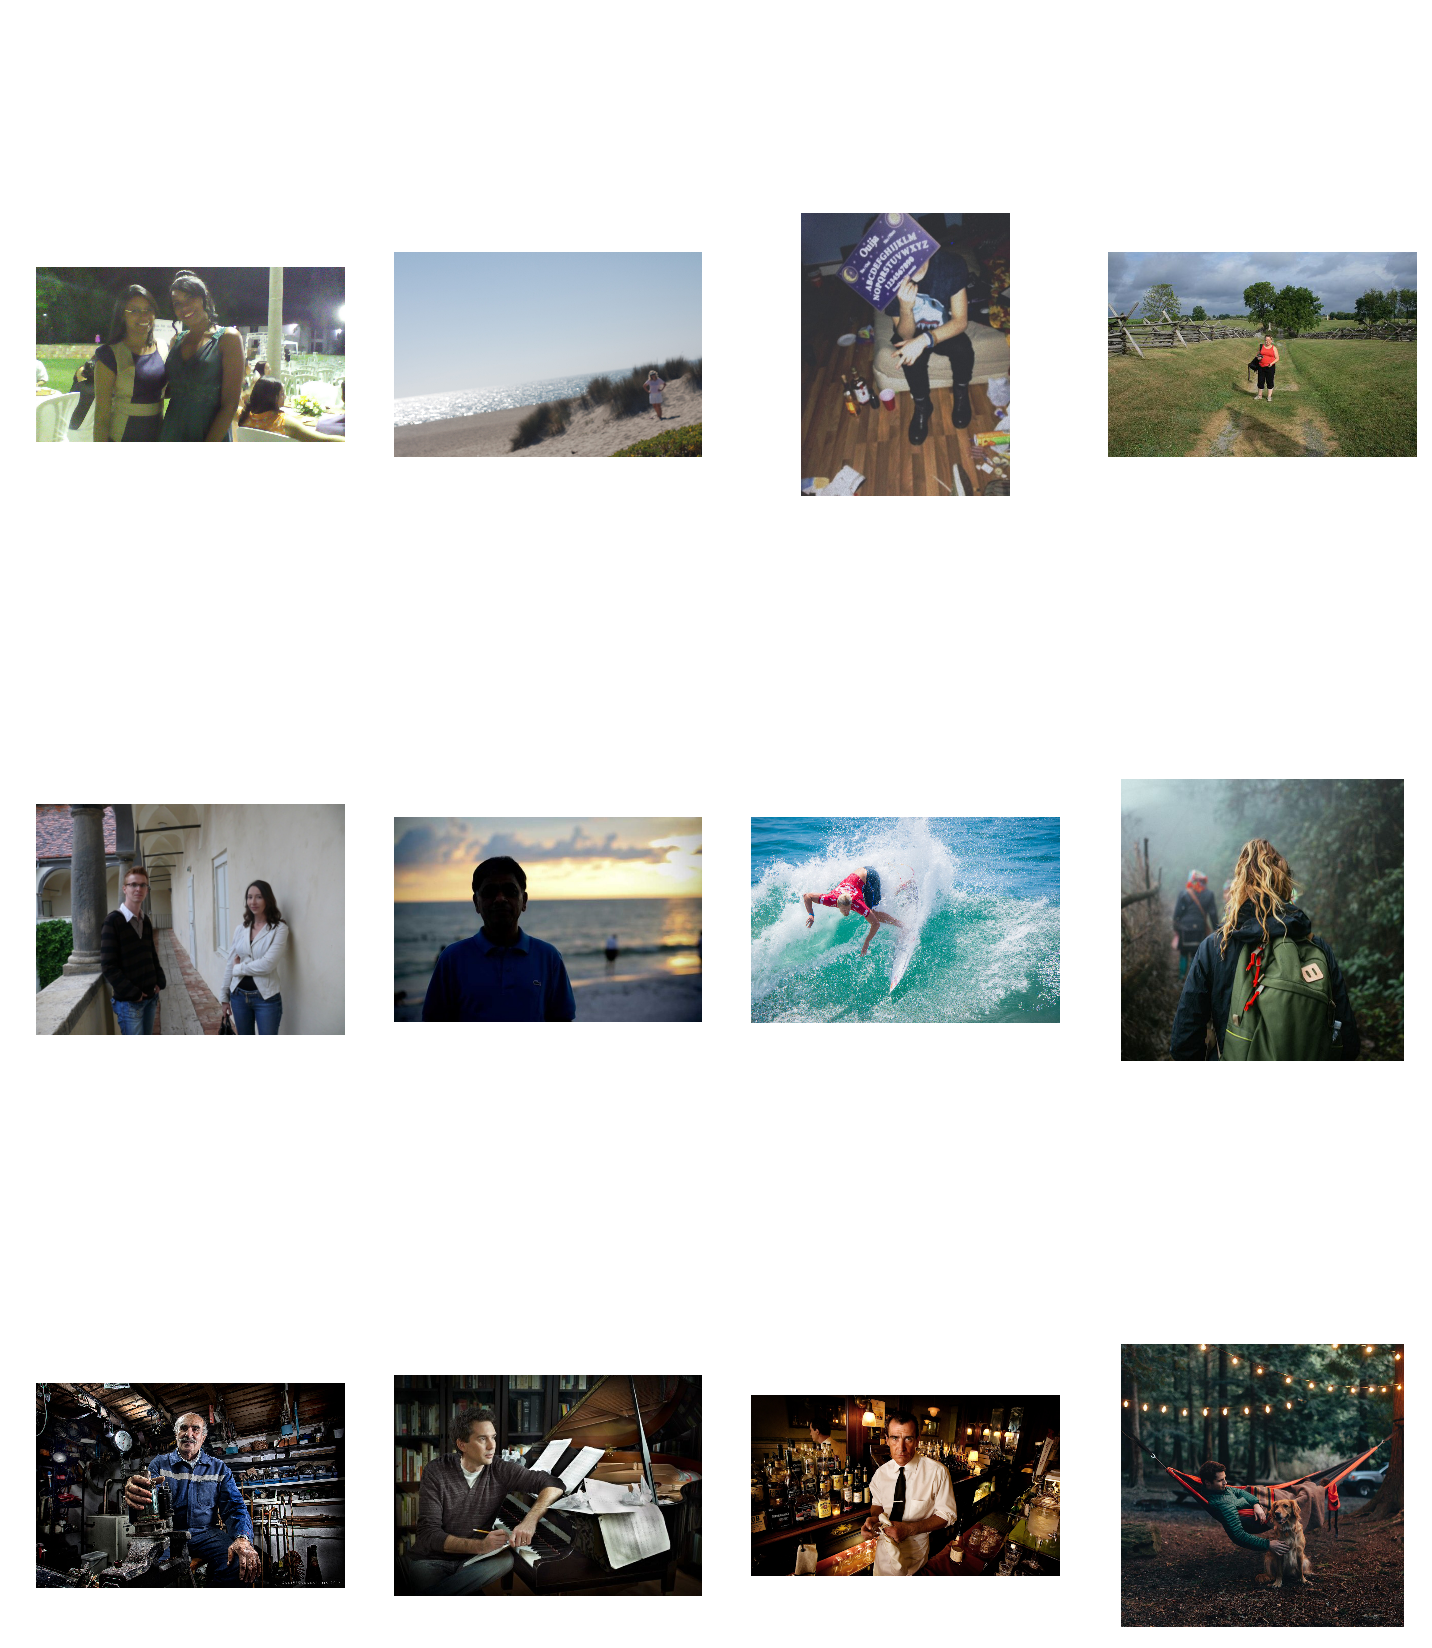

In [6]:
# Reading image paths
test_img_paths = [img_path for img_path in glob.glob(IMAGE_FILE)]
test_img_paths.sort()

#Making predictions
entry = {}
fig = plt.figure(figsize=(20, 20))

for i, img_path in enumerate(test_img_paths):
    image_name = os.path.basename(img_path)    
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)

    net.blobs[input_layer].data[...] = transformer.preprocess(input_layer, img)
    out = net.forward()
    entry[image_name] = out
    
    out_text = ''
    for feature in out:
        out_text += feature+': '+str(out[feature][0][0])+'\n'
    
    ax = plt.subplot(3, 4, 1+i)
    _=ax.imshow(plt.imread(img_path))
    _=ax.text(1, 0, out_text, size=14, color='white')
    _=ax.axis('off')
    
plt.tight_layout()
plt.subplots_adjust(hspace=1)
plt.show()